['G' 'L' 'G' 'G' 'L' 'G' 'L' 'L' 'G' 'G' 'G' 'L' 'G' 'G' 'G' 'L' 'G' 'L'
 'L' 'L' 'G' 'L' 'L' 'G' 'L' 'L' 'G' 'G' 'L' 'G' 'L' 'G' 'G' 'G' 'L' 'L'
 'G' 'G' 'G' 'L' 'L' 'G' 'L' 'G' 'L' 'L' 'L' 'G' 'L' 'L' 'L' 'L' 'G' 'G'
 'G' 'G' 'L' 'L' 'L' 'L' 'G' 'G' 'L' 'L' 'L' 'L' 'L' 'L' 'G' 'G' 'G' 'L'
 'L' 'G' 'L' 'L' 'L' 'G' 'L' 'G' 'L' 'L' 'L' 'G' 'G' 'L' 'L' 'G' 'G' 'G'
 'L' 'G' 'L' 'G' 'G' 'G' 'G' 'L' 'L' 'G' 'G' 'L' 'G' 'L' 'G' 'L' 'L' 'G'
 'L' 'L' 'G' 'L' 'G' 'G' 'G' 'L' 'L' 'G' 'G' 'L' 'L' 'G' 'L' 'G' 'G' 'G'
 'L' 'G' 'L' 'L' 'G' 'L' 'L' 'L' 'G' 'G' 'L' 'L' 'L' 'G' 'G' 'G' 'G' 'G'
 'L' 'G' 'G' 'L' 'L' 'L' 'L' 'L' 'G' 'L' 'G' 'G' 'G' 'L' 'G' 'L' 'G' 'L'
 'L' 'G' 'L' 'L' 'L' 'G' 'G' 'G' 'G' 'L' 'G' 'L' 'G' 'L' 'G' 'L' 'G' 'L'
 'L' 'G' 'G' 'L' 'G' 'G' 'L' 'L' 'G' 'G' 'L' 'G' 'L' 'G' 'G' 'G' 'L' 'G'
 'G' 'G' 'G' 'G' 'L' 'G' 'L' 'L' 'G' 'G' 'G' 'G' 'L' 'L' 'G' 'L' 'L' 'L'
 'L' 'G' 'L' 'G' 'G' 'G' 'L' 'G' 'G' 'L' 'G' 'G' 'L' 'L' 'G' 'G' 'L' 'L'
 'G' 'G' 'G' 'L' 'L' 'L' 'L' 'L' 'G' 'G' 'G' 'L' 'L

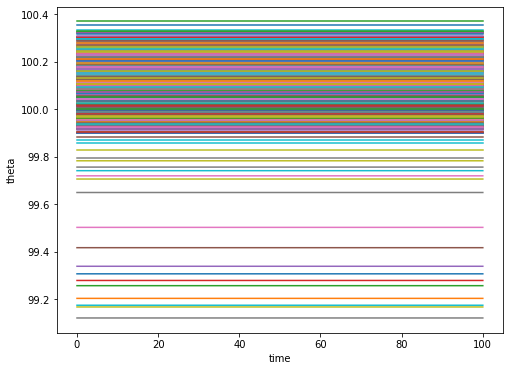

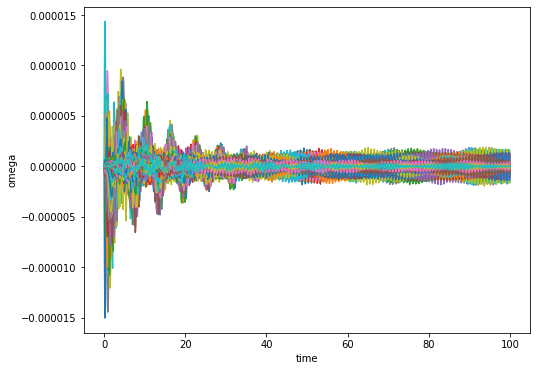

In [6]:
import numpy as np
import networkx as nx
from Assign_Gen_Load_Power import assign_gen_load_power
# from Assign_Bus_Line_Idx import assign_bus_line_idx
from Compute_Steady_States import compute_steady_states
from Solve_Dynamics import solve_dynamics
# from Compute_Line_Flow import compute_line_flow
from Compute_Theta_Omega import compute_theta_omega
# from Assing_Line_Capacity import assing_line_capacity
# from Check_Line_Overload import check_line_overload
# from Assign_Tstart_Tend import assign_tstart_tend

# from Sort_Lines import sort_lines
# from CutOff_Ovl import cutoff_ovl
# from Cascade_Propagation import cascade_propagation
# from Cascade_Mitigation import cascade_mitigation
# from Cascade_Mitigation_Gi_2 import cascade_mitigation_gi_2
# from Linear_Response_Matrix import compute_Gij_Gij_n
# from network_load import network_load
# from Compute_Gi import compute_Gi
import matplotlib.pyplot as plt
import copy
import random
import time


if __name__ == "__main__":
    nbus = 1000
    ngen = 500
    nload = nbus - ngen
    d = 2
    K = 10.0  # scaler coupling parameter
    alpha = 1.2
    pgen = 1.0
    pload = -1.0
    PGmax = 1.1*pgen
    PGmin = 0.9*pgen
    gamma = 0.1    
    gen_idx, load_idx, power, nodetype = assign_gen_load_power(pgen, pload, ngen, nload, nbus)
    print(nodetype)
    #     power = np.zeros(nbus, dtype=float)
    #     g0 = nx.connected_watts_strogatz_graph(nbus, k, p, tries=100, seed=246)
    g0 = nx.watts_strogatz_graph(nbus, k=4, p=0.2, seed=246)
    #net_type = 'swn_heterogeneous'
    #     g0 = nx.barabasi_albert_graph(nbus, m=2, seed=None)
    #     net_type = 'sfn'
    lines = list(g0.edges())  # list containing the source and target nodes for all edges
    nlines = g0.number_of_edges()
    print(f'number of nodes = {nbus}, number of lines = {nlines}')
    adj = nx.adjacency_matrix(g0, nodelist=None, weight=None)
    adj = adj.toarray()
#     bus_idx, line_idx = assign_bus_line_idx(nbus, nlines)

    # Compute Steady States Only
#     theta0 = np.zeros(nbus)
#     theta = np.ones(nbus)
    theta0 = np.full((nbus,),100)
    start = time.perf_counter()
    ss_theta = compute_steady_states(g0, power, K, nbus, theta0)
    finish = time.perf_counter()
    print(f'compute_steady_state finished in {round(finish - start, 3)} second(s)')
    
    # Testing Steady States
    y0 = np.zeros(nbus*d)
    for i in range(nbus):
        y0[i*d+0] = ss_theta[i]
    ti = 0.0; tf = 100.0; tint = 1001
    tspan, sol = solve_dynamics(g0, y0, power, gamma, K, nbus, d, ti, tf, tint)
    start = time.perf_counter()
    theta, omega = compute_theta_omega(sol, nbus, d)
    finish = time.perf_counter()
    print(f'compute_theta_omega finished in {(finish-start):.3f} seconds')
    fig1 = plt.figure(figsize = (8,6))
    plt.plot(tspan,theta,'-')
    plt.xlabel('time')
    plt.ylabel('theta')
    plt.show()    
    fig2 = plt.figure(figsize = (8,6))
    plt.plot(tspan,omega,'-')
    plt.xlabel('time')
    plt.ylabel('omega')
    plt.show()

In [4]:
nodetype[0]

'L'